In [1]:
import numpy as np

# Define the grid size and actions
grid_size = 5
n_actions = 4  # Actions: up, down, left, right

# Initialize the Q-table with zeros
Q_table = np.zeros((grid_size * grid_size, n_actions))

In [2]:
alpha = 0.1  # Learning rate
gamma = 0.9  # Discount factor for future rewards
epsilon = 0.1  # Exploration rate for epsilon-greedy policy

In [3]:
# Reward matrix for the grid environment
rewards = np.full((grid_size * grid_size,), -1)  # -1 for every state
rewards[24] = 10  # Goal state
rewards[12] = -10  # Pitfall state

In [5]:
# Implement the epsilon-greedy action selection
def epsilon_greedy_action(Q_table, state, epsilon):
    if np.random.uniform(0, 1) < epsilon:
        return np.random.randint(0, n_actions)  # Explore: random action
    else:
        return np.argmax(Q_table[state])  # Exploit: action with highest Q-value

In [14]:
# Update the Q-values with the Bellman Equation
for episode in range(1000):
    state = np.random.randint(0, grid_size * grid_size)  # Start in a random state
    total_reward = 0   # <-- CHANGED: reset total reward at episode start

    done = False
    while not done:
        action = epsilon_greedy_action(Q_table, state, epsilon)
        next_state = np.random.randint(0, grid_size * grid_size)  # Simulated next state
        reward = rewards[next_state]

        total_reward += reward  # <-- CHANGED: accumulate step reward

        # Update Q-value using Bellman equation
        Q_table[state, action] = (
            Q_table[state, action]
            + alpha * (reward + gamma * np.max(Q_table[next_state]) - Q_table[state, action])
        )

        state = next_state
        if next_state == 24 or next_state == 12:
            done = True

    rewards_q_learning.append(total_reward)  # <-- CHANGED: record total reward after episode

In [7]:
import tensorflow as tf

# Define the policy network
n_states = grid_size * grid_size  # Number of states in the grid
n_actions = 4  # Up, down, left, right

model = tf.keras.Sequential([
    tf.keras.layers.Dense(24, activation='relu', input_shape=(n_states,)),
    tf.keras.layers.Dense(n_actions, activation='softmax')  # Output action probabilities
])

# Optimizer for policy network updates
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

C:\Users\Spyqi\PycharmProjects\Azure-ML-Practice\ReinforcementLearning\.venv\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
# Tracking cumulative rewards for policy gradients plotting
rewards_policy_gradients = []    # <-- CHANGED: initialize list for per-episode rewards

In [8]:
def get_action(state):
    state_input = tf.one_hot(state, n_states)  # One-hot encoding for state
    action_probs = model(state_input[np.newaxis, :])
    return np.random.choice(n_actions, p=action_probs.numpy()[0])

In [17]:
def update_policy(states, actions, rewards):
    cumulative_rewards = compute_cumulative_rewards(rewards)

    with tf.GradientTape() as tape:
        state_inputs = tf.one_hot(states, n_states)  # Convert states to one-hot encoding
        action_probs = model(state_inputs)
        action_masks = tf.one_hot(actions, n_actions)  # Mask for selected actions
        log_probs = tf.reduce_sum(action_masks * tf.math.log(action_probs), axis=1)

        # Policy loss is the negative log-probability of the action times the cumulative reward
        loss = -tf.reduce_mean(log_probs * cumulative_rewards)

    # Apply gradients to update the policy network
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [18]:
# Simulation loop
states = []
actions = []
episode_rewards = []

for episode in range(1000):
    state = np.random.randint(0, n_states)  # Start in a random state
    done = False
    while not done:
        action = get_action(state)  # Use the provided function
        next_state = np.random.randint(0, n_states)  # Simulated next state
        reward = rewards[next_state]

        # Store the state-action-reward trajectory
        states.append(state)
        actions.append(action)
        episode_rewards.append(reward)

        state = next_state
        if next_state in {24, 12}:
            done = True
    # Update policy network after collecting trajectory
    update_policy(states, actions, episode_rewards)

    # Record the sum of this episode's rewards for plotting
    rewards_policy_gradients.append(sum(episode_rewards))  # <-- CHANGED: append cumulative reward

    # Clear trajectory data for next episode
    states, actions, episode_rewards = [], [], []

In [19]:
def compute_cumulative_rewards(rewards, gamma=0.99):
    cumulative_rewards = np.zeros_like(rewards)
    running_add = 0
    for t in reversed(range(len(rewards))):
        running_add = running_add * gamma + rewards[t]
        cumulative_rewards[t] = running_add
    return cumulative_rewards

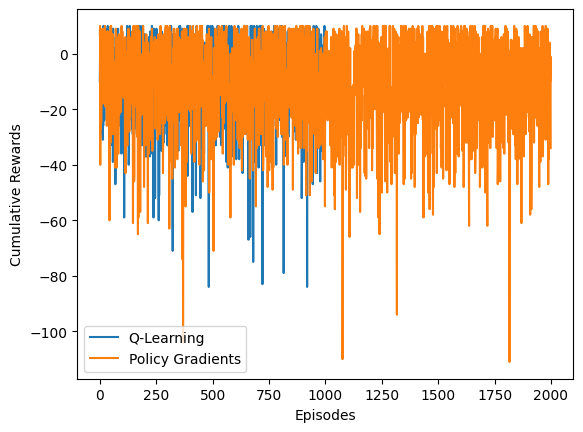

In [21]:
import matplotlib.pyplot as plt

# Example code to visualize rewards over episodes
plt.plot(rewards_q_learning, label='Q-Learning')
plt.plot(rewards_policy_gradients, label='Policy Gradients')
plt.xlabel('Episodes')
plt.ylabel('Cumulative Rewards')
plt.legend()
plt.show()